# IMPORT LIBRARIES

In [3]:
# Operating system and path manipulation
import os
from pathlib import Path

# Data manipulation and analysis
import numpy as np
import pandas as pd
import polars as pl
from polars import StringCache

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Regular expressions
import re

# Machine learning imports

# Model selection and evaluation
from sklearn.model_selection import StratifiedGroupKFold, cross_val_score
from sklearn.metrics import roc_auc_score, recall_score

# Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

# Ensemble methods
from sklearn.ensemble import VotingClassifier

# Dimensionality reduction
from sklearn.decomposition import PCA

# Pipelines
from sklearn.pipeline import Pipeline

# Imbalanced learning
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.impute import SimpleImputer

# Collections
from collections import Counter

# Gradient boosting models
import lightgbm as lgb
import catboost as cb
import xgboost as xgb

# Hyperparameter optimization
import optuna
from optuna.samplers import TPESampler

# Timing
import time

# Feature selection
# from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, VarianceThreshold

# HELPER FUNCTIONS

In [4]:
def print_df_info(df):
    # Count the number of columns by data type
    int_cols = df.select_dtypes(include=['int']).shape[1]
    float_cols = df.select_dtypes(include=['float']).shape[1]
    cat_cols = df.select_dtypes(include=['category']).shape[1]
    obj_cols = df.select_dtypes(include=['object']).shape[1]

    # Calculate the total number of nulls in the DataFrame
    total_nulls = df.isnull().sum().sum()
    shape = df.shape
    
    # Print the results
    print(f"Shape: {shape}")
    print(f"Number of integer columns: {int_cols}")
    print(f"Number of float columns: {float_cols}")
    print(f"Number of categorical columns: {cat_cols}")
    print(f"Number of object columns: {obj_cols}")
    print(f"Total number of nulls in the DataFrame: {total_nulls}")
    
def custom_metric(estimator, X, y_true):
    y_hat = estimator.predict_proba(X)[:, 1]
    min_tpr = 0.80
    max_fpr = abs(1 - min_tpr)
    
    v_gt = abs(y_true - 1)
    v_pred = np.array([1.0 - x for x in y_hat])
    
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    
    return partial_auc

def recall_metric(y_true: np.ndarray, y_pred: np.ndarray, threshold: float=0.5) -> float:
    
    # Convert probabilities to binary predictions using the specified threshold
    y_pred_binary = (y_pred >= threshold).astype(int)
    
    # Compute recall score
    recall = recall_score(y_true, y_pred_binary)
    return recall
    
def downsample_data_pl(df: pd.DataFrame, neg_ratio: float = None, seed: int = None) -> pd.DataFrame:
    # Extract the counts of positive and negative cases
    p_cases = df[df['target'] == 1]
    n_cases = df[df['target'] == 0]
    
    # If neg_ratio is None use all negative samples
    if neg_ratio is not None:
        N = int(len(p_cases) * neg_ratio)
        n_cases = n_cases.sample(n=N, random_state=seed)
    
    # Concatenate the negative and positive cases
    df_downsampled = pd.concat([n_cases, p_cases])
    
    return df_downsampled

def smote_oversample(X, y, sampling_strategy=0.1, k_neighbors=2, random_state=None):
     
    smote = SMOTE(sampling_strategy=sampling_strategy, k_neighbors=k_neighbors, random_state=random_state)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    
    return X_resampled, y_resampled

def pca_analysis_with_elbow(df_numeric, threshold_range=[0.7, 0.8, 0.9, 0.95, 0.99], title="Elbow Method for Optimal n_components"):
    # Standardize numeric data (recommended for PCA)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_numeric)
    
    # Perform PCA
    pca = PCA()
    pca.fit(X_scaled)

    # Calculate cumulative explained variance ratio
    cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

    # Determine optimal number of components for each threshold
    n_components_by_threshold = {}
    for threshold in threshold_range:
        n_components_by_threshold[threshold] = np.argmax(cumulative_variance_ratio >= threshold) + 1

    # Choose optimal number of components based on the default threshold (0.95)
    optimal_threshold = 0.95
    optimal_n_components = n_components_by_threshold[optimal_threshold]

    # Plot the elbow curve
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title(title)
    plt.axvline(optimal_n_components, color='r', linestyle='--', label=f'Optimal n_components ({optimal_n_components})')  # Highlight chosen n_components
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print(f"Optimal number of components to explain at least {optimal_threshold}% of variance: {optimal_n_components}")
    return n_components_by_threshold

def apply_pca_and_concat(df, pca_pipeline, num_cols, cat_cols, image_cols):
    
    # Transform numerical columns with PCA pipeline
    pca_transformed = pca_pipeline.transform(df[num_cols])
    # Generate PCA component column names
    pca_column_names = [f'PCA_{i+1}' for i in range(pca_transformed.shape[1])]
    # Convert PCA transformed data to DataFrame
    pca_df = pd.DataFrame(pca_transformed, columns=pca_column_names, index=df.index)
    # Extract non-PCA columns from the original DataFrame
    non_pca_df = df[cat_cols + image_cols]
    # Combine PCA DataFrame with non-PCA columns
    final_df = pd.concat([pca_df, non_pca_df], axis=1)
    
    return final_df, pca_column_names

# IMAGE PREDICTIONS

In [5]:
!python /kaggle/input/isic2024-all-models-inference-main-py/main.py --models efficientnet_b0 mixnet_s mobilenetv2_050 ghostnet_100
!mv test_preds_ER.csv submission_all_models_er.csv
!ls

Available Models: ['efficientnet_b0', 'mixnet_s', 'efficientvit_b0', 'mobilenetv2_050', 'ghostnet_100']
Creating loader...
Running inference on efficientnet_b0...
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.01it/s]
Inference completed for efficientnet_b0.
---------------------------------------
Running inference on mixnet_s...
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.35it/s]
Inference completed for mixnet_s.
---------------------------------------
Running inference on mobilenetv2_050...
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 11.61it/s]
Inference completed for mobilenetv2_050.
---------------------------------------
Running inference on ghostnet_100...
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.82it/s]
Inference completed for ghostnet_100.
---------------------------------------
submission_all_models_er.csv


# DATA PREPROCESS

In [6]:
root = Path('/kaggle/input/isic-2024-challenge')

train_path = root / 'train-metadata.csv'
test_path = root / 'test-metadata.csv'
subm_path = root / 'sample_submission.csv'

path_effb0_train = "/kaggle/input/isic-inference-effnetv1b0-for-training-data/train_effnetv1b0.csv"
path_target3_train = "/kaggle/input/isic-2024-pl-submission-script-and-preds/train_preds.csv"
path_eva02_train = "/kaggle/input/isic-inference-eva02-for-training-data/train_eva02.csv"
path_edgenext_train = "/kaggle/input/isic-inference-edgenext-for-training-data/train_edgenext.csv"

id_col = 'isic_id'
target_col = 'target'
group_col = 'patient_id'

err = 1e-5
seed = 23

In [7]:
class ISIC2024_Preprocessing:
    
    def __init__(self):
        pass
    
    def filter_data(self, path):
    
        # Read dataset as polars DataFrame
        df = pl.read_csv(path, low_memory=True)
            
        # Drop redundant columns 
        for col in [
                    'image_type', # Only one unique value on train metadata
                    'copyright_license', # Redundant information for lesion classification
                    # Included only on train metadata
                    'lesion_id',
                    'iddx_full',
                    'iddx_1',
                    'iddx_2',
                    'iddx_3',
                    'iddx_4',
                    'iddx_5',
                    'mel_mitotic_index',
                    'mel_thick_mm',
                    'tbp_lv_dnn_lesion_confidence']:
            
            if col in df.columns:
                df = df.drop(col)            

        return df 
    
    def set_datatypes(self, df):
                  
        # Define numeric columns (int)
        for col in ['target',
                    'tbp_lv_symm_2axis_angle']:
            
            # Set dtype for numeric columns (int)
            if col in df.columns:
                df = df.with_columns(pl.col(col).cast(pl.Int16))
                        
        # Define numeric columns (float)
        for col in ['clin_size_long_diam_mm', 
                    'tbp_lv_A', 
                    'tbp_lv_Aext', 
                    'tbp_lv_B', 
                    'tbp_lv_Bext', 
                    'tbp_lv_C', 
                    'tbp_lv_Cext',
                    'tbp_lv_H', 
                    'tbp_lv_Hext',
                    'tbp_lv_L', 
                    'tbp_lv_Lext',
                    'tbp_lv_areaMM2', 
                    'tbp_lv_area_perim_ratio',
                    'tbp_lv_color_std_mean',
                    'tbp_lv_deltaA', 
                    'tbp_lv_deltaB',
                    'tbp_lv_deltaL', 
                    'tbp_lv_deltaLB',
                    'tbp_lv_deltaLBnorm',
                    'tbp_lv_eccentricity', 
                    'tbp_lv_minorAxisMM',
                    'tbp_lv_nevi_confidence',
                    'tbp_lv_norm_border',
                    'tbp_lv_norm_color',
                    'tbp_lv_perimeterMM',
                    'tbp_lv_radial_color_std_max',
                    'tbp_lv_stdL',
                    'tbp_lv_stdLExt',
                    'tbp_lv_symm_2axis',
                    'tbp_lv_x',
                    'tbp_lv_y',
                    'tbp_lv_z']: 
            
            # Set dtype for numeric columns (float)
            if col in df.columns:
                df = df.with_columns(pl.col(col).cast(pl.Float64))
                
        # Define categorical columns
        for col in ['sex', 
                    'anatom_site_general', 
                    'tbp_tile_type', 
                    'tbp_lv_location',
                    'tbp_lv_location_simple',
                    'attribution']:
            
            # Set dtype for categorical columns
            if col in df.columns:
                df = df.with_columns(pl.col(col).cast(pl.Categorical))
                                            
        return df
    
    def feature_engineering(self, df):
        
        return (
            df.with_columns(
                pl.col('age_approx').cast(pl.String).replace('NA', np.nan).cast(pl.Float64),
            )
            .with_columns(
                pl.col(pl.Float64).fill_nan(pl.col(pl.Float64).median()), #Impute test with train?
            )
            .with_columns(
                lesion_size_ratio              = pl.col('tbp_lv_minorAxisMM') / pl.col('clin_size_long_diam_mm'),
                lesion_shape_index             = pl.col('tbp_lv_areaMM2') / (pl.col('tbp_lv_perimeterMM') ** 2),
                hue_contrast                   = (pl.col('tbp_lv_H') - pl.col('tbp_lv_Hext')).abs(),
                luminance_contrast             = (pl.col('tbp_lv_L') - pl.col('tbp_lv_Lext')).abs(),
                lesion_color_difference        = (pl.col('tbp_lv_deltaA') ** 2 + pl.col('tbp_lv_deltaB') ** 2 + pl.col('tbp_lv_deltaL') ** 2).sqrt(),
                border_complexity              = pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_symm_2axis'),
                color_uniformity               = pl.col('tbp_lv_color_std_mean') / (pl.col('tbp_lv_radial_color_std_max') + err),
            )
            .with_columns(
                position_distance_3d           = (pl.col('tbp_lv_x') ** 2 + pl.col('tbp_lv_y') ** 2 + pl.col('tbp_lv_z') ** 2).sqrt(),
                perimeter_to_area_ratio        = pl.col('tbp_lv_perimeterMM') / pl.col('tbp_lv_areaMM2'),
                area_to_perimeter_ratio        = pl.col('tbp_lv_areaMM2') / pl.col('tbp_lv_perimeterMM'),
                lesion_visibility_score        = pl.col('tbp_lv_deltaLBnorm') + pl.col('tbp_lv_norm_color'),
#                 combined_anatomical_site       = (pl.col('anatom_site_general') + '_' + pl.col('tbp_lv_location')).cast(pl.Categorical),
                symmetry_border_consistency    = pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_norm_border'),
                consistency_symmetry_border    = pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_norm_border') / (pl.col('tbp_lv_symm_2axis') + pl.col('tbp_lv_norm_border')),
            )
            .with_columns(
                color_consistency              = pl.col('tbp_lv_stdL') / pl.col('tbp_lv_Lext'),
                consistency_color              = pl.col('tbp_lv_stdL') * pl.col('tbp_lv_Lext') / (pl.col('tbp_lv_stdL') + pl.col('tbp_lv_Lext')),
                size_age_interaction           = pl.col('clin_size_long_diam_mm') * pl.col('age_approx'),
                hue_color_std_interaction      = pl.col('tbp_lv_H') * pl.col('tbp_lv_color_std_mean'),
                lesion_severity_index          = (pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_norm_color') + pl.col('tbp_lv_eccentricity')) / 3,
                shape_complexity_index         = pl.col('border_complexity') + pl.col('lesion_shape_index'),
                color_contrast_index           = pl.col('tbp_lv_deltaA') + pl.col('tbp_lv_deltaB') + pl.col('tbp_lv_deltaL') + pl.col('tbp_lv_deltaLBnorm'),
            )
            .with_columns(
                log_lesion_area                = (pl.col('tbp_lv_areaMM2') + 1).log(),
                normalized_lesion_size         = pl.col('clin_size_long_diam_mm') / pl.col('age_approx'),
                mean_hue_difference            = (pl.col('tbp_lv_H') + pl.col('tbp_lv_Hext')) / 2,
                std_dev_contrast               = ((pl.col('tbp_lv_deltaA') ** 2 + pl.col('tbp_lv_deltaB') ** 2 + pl.col('tbp_lv_deltaL') ** 2) / 3).sqrt(),
                color_shape_composite_index    = (pl.col('tbp_lv_color_std_mean') + pl.col('tbp_lv_area_perim_ratio') + pl.col('tbp_lv_symm_2axis')) / 3,
                lesion_orientation_3d          = pl.arctan2(pl.col('tbp_lv_y'), pl.col('tbp_lv_x')),
                overall_color_difference       = (pl.col('tbp_lv_deltaA') + pl.col('tbp_lv_deltaB') + pl.col('tbp_lv_deltaL')) / 3,
            )
            .with_columns(
                symmetry_perimeter_interaction = pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_perimeterMM'),
                comprehensive_lesion_index     = (pl.col('tbp_lv_area_perim_ratio') + pl.col('tbp_lv_eccentricity') + pl.col('tbp_lv_norm_color') + pl.col('tbp_lv_symm_2axis')) / 4,
                color_variance_ratio           = pl.col('tbp_lv_color_std_mean') / pl.col('tbp_lv_stdLExt'),
                border_color_interaction       = pl.col('tbp_lv_norm_border') * pl.col('tbp_lv_norm_color'),
                border_color_interaction_2     = pl.col('tbp_lv_norm_border') * pl.col('tbp_lv_norm_color') / (pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_norm_color')),
                size_color_contrast_ratio      = pl.col('clin_size_long_diam_mm') / pl.col('tbp_lv_deltaLBnorm'),
                age_normalized_nevi_confidence = pl.col('tbp_lv_nevi_confidence') / pl.col('age_approx'),
                age_normalized_nevi_confidence_2 = (pl.col('clin_size_long_diam_mm')**2 + pl.col('age_approx')**2).sqrt(),
                color_asymmetry_index          = pl.col('tbp_lv_radial_color_std_max') * pl.col('tbp_lv_symm_2axis'),
            )
            .with_columns(
                volume_approximation_3d        = pl.col('tbp_lv_areaMM2') * (pl.col('tbp_lv_x')**2 + pl.col('tbp_lv_y')**2 + pl.col('tbp_lv_z')**2).sqrt(),
                color_range                    = (pl.col('tbp_lv_L') - pl.col('tbp_lv_Lext')).abs() + (pl.col('tbp_lv_A') - pl.col('tbp_lv_Aext')).abs() + (pl.col('tbp_lv_B') - pl.col('tbp_lv_Bext')).abs(),
                shape_color_consistency        = pl.col('tbp_lv_eccentricity') * pl.col('tbp_lv_color_std_mean'),
                border_length_ratio            = pl.col('tbp_lv_perimeterMM') / (2 * np.pi * (pl.col('tbp_lv_areaMM2') / np.pi).sqrt()),
                age_size_symmetry_index        = pl.col('age_approx') * pl.col('clin_size_long_diam_mm') * pl.col('tbp_lv_symm_2axis'),
                index_age_size_symmetry        = pl.col('age_approx') * pl.col('tbp_lv_areaMM2') * pl.col('tbp_lv_symm_2axis'),
            )
        )
        
    def extract_cat_num_cols(self, df):
        # Define lists to hold categorical and numeric columns
        cat_cols = []
        num_cols = []
        
        # Iterate through columns to determine their types
        for col in df.columns:
            if col != 'target':
                if df[col].dtype == pl.Categorical:
                    cat_cols.append(col)
                elif df[col].dtype in [pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64, pl.Float64, pl.Float64]:
                    num_cols.append(col)
                
        return cat_cols, num_cols
  
    def normal_features(self, df, num_cols, err = 1e-05):
        
        df = df.with_columns(
                ((pl.col(col) - pl.col(col).mean().over('patient_id')) / (pl.col(col).std().over('patient_id') + err)).alias(f'{col}_patient_norm') for col in num_cols
        ).with_columns(
                count_per_patient=pl.col('isic_id').count().over('patient_id').cast(pl.Int16),
        )
        
        # Add age bin categorical
        def age_bin(age):
            if age <= 20:
                return 'young'
            elif age <= 40:
                return 'young_adult'
            elif age <= 60:
                return 'adult'
            else:
                return 'old'

        df = df.with_columns(pl.col('age_approx').map_elements(age_bin, return_dtype=pl.String).alias('age_bin').cast(pl.Categorical))
       
        return df

    def process_data(self, path):
        with StringCache():
            df = self.filter_data(path)
            df = self.set_datatypes(df)
            df = self.feature_engineering(df)
        cat_cols, num_cols = self.extract_cat_num_cols(df)
        df = self.normal_features(df, num_cols)
        _, full_num_cols = self.extract_cat_num_cols(df)
        
        return df, cat_cols, num_cols, full_num_cols

In [12]:
pp = ISIC2024_Preprocessing()
df_train, cat_cols, num_cols, full_num_cols = pp.process_data(path=train_path)
df_test, _ , _, _= pp.process_data(path=test_path)

In [13]:
# Additional features grouped by cat cols
cat_cols += ['age_bin']

def create_aggregated_features(df, cat_cols, num_cols):
    result = df.clone()
    for cat_col in cat_cols:
        agg_exprs = []
        for num_col in num_cols:
            agg_exprs.extend([
                pl.col(num_col).mean().alias(f"{cat_col}_{num_col}_mean"),
                pl.col(num_col).std().alias(f"{cat_col}_{num_col}_std"),
#                 pl.col(num_col).max().alias(f"{cat_col}_{num_col}_max"),
#                 pl.col(num_col).min().alias(f"{cat_col}_{num_col}_min")
            ])
        
      
        agg_df = df.group_by(cat_col).agg(agg_exprs)
        result = result.join(agg_df, on=cat_col, how="left")
    
    return result

In [14]:
# top_features = ['tbp_lv_location', 'tbp_lv_H_patient_norm', 'age_approx', 'tbp_lv_perimeterMM', 'color_uniformity', 'age_approx_patient_norm', 'position_distance_3d_patient_norm', 'sex', 'tbp_lv_L', 'clin_size_long_diam_mm', 'age_normalized_nevi_confidence_2', 'target_effnetv1b0', 'color_uniformity_patient_norm', 'tbp_lv_y_patient_norm', 'tbp_lv_B', 'tbp_lv_Lext', 'lesion_color_difference_patient_norm', 'position_distance_3d', 'std_dev_contrast', 'size_age_interaction_patient_norm', 'tbp_lv_y', 'count_per_patient', 'target_3', 'attribution', 'tbp_lv_H', 'age_normalized_nevi_confidence_2_patient_norm']

In [15]:
selected_top = [
    'tbp_lv_perimeterMM',
    'color_uniformity',
    'tbp_lv_areaMM2',
    'clin_size_long_diam_mm',
]

selected_agg = [
    'anatom_site_general',
    'attribution',
    'age_bin'
]

train_cols = set(df_train.columns)
df_train = create_aggregated_features(df_train, selected_agg, selected_top)
df_test = create_aggregated_features(df_test, selected_agg, selected_top)

agg_cols = list(set(df_train.columns) - train_cols)

In [16]:
def process_polars(df_train, df_test):
    
    # Add image features

    preds = [
            ('efficientnet', 'target_Full_train_efficientnet_b0_final_AUROC0.9666_Loss0.2627_epoch20'),
            ('mixnet', 'target_Full_train_mixnet_s_final_AUROC0.9722_Loss0.2587_epoch18'),
#             ('efficientvit', 'target_Full_train_efficientvit_b0_2_final_AUROC0.9130_Loss0.3968_epoch19'),
            ('mobilenetv2', 'target_Full_train_mobilenetv2_050_final_AUROC0.9459_Loss0.3309_epoch20'),
            ('ghostnet', 'target_Full_train_ghostnet_100_final_AUROC0.9679_Loss0.2483_epoch20')
        ]

    df_er_train = pl.read_csv('/kaggle/input/isic2024-all-models-inference-for-train/All_models_train_predictions_ER.csv')
    df_er_test = pl.read_csv("submission_all_models_er.csv")

    for model_name, pred_name in preds:
        df_train = df_train.with_columns(df_er_train[pred_name].alias(model_name))
        df_test = df_test.with_columns(df_er_test[pred_name].alias(model_name))

    return df_train.to_pandas(), df_test.to_pandas()

In [17]:
image_cols = [
                'efficientnet', 
                'mixnet',
#                 'efficientvit',
                'mobilenetv2',
                'ghostnet'
]

norm_cols = list(set(full_num_cols) - set(num_cols))

In [18]:
%%time
df_subm = pd.read_csv(subm_path, index_col=id_col)

df_train, df_test = process_polars(df_train, df_test)
feature_cols = cat_cols + full_num_cols + image_cols + agg_cols

print("\nFINAL TRAIN INFORMATION:")
print_df_info(df_train)
print("\nFINAL TEST INFORMATION:")
print_df_info(df_test)

# Final categorical columns
print(f"\nFinal categorical columns: \n{cat_cols}")


FINAL TRAIN INFORMATION:
Shape: (401059, 191)
Number of integer columns: 0
Number of float columns: 179
Number of categorical columns: 7
Number of object columns: 2
Total number of nulls in the DataFrame: 380

FINAL TEST INFORMATION:
Shape: (3, 190)
Number of integer columns: 0
Number of float columns: 179
Number of categorical columns: 7
Number of object columns: 2
Total number of nulls in the DataFrame: 256

Final categorical columns: 
['sex', 'anatom_site_general', 'tbp_tile_type', 'tbp_lv_location', 'tbp_lv_location_simple', 'attribution', 'age_bin']
CPU times: user 1.17 s, sys: 629 ms, total: 1.8 s
Wall time: 1.08 s


# BRING THE NOISE!

Both models really prioritize the image predictions so I will add some noise to decrease their feature importance.

In [19]:
def multiply_noise_to_column(df, column_name, random_seed=None, noise_mean=0, noise_std=0.01, clip_min=None, clip_max=None):
    if random_seed is not None:
        np.random.seed(random_seed)
    
    noise = np.random.normal(loc=noise_mean, scale=noise_std, size=len(df))
    df[column_name] *= (1 + noise)
    
    if clip_min is not None and clip_max is not None:
        df[column_name] = df[column_name].clip(clip_min, clip_max)
    
    return df

In [20]:
# df = df_train.copy()
# image_col_name = "efficientnet"
# NOISE = 0.01

# print(f"Before processing: {df[image_col_name].describe()}", "AUC:", roc_auc_score(df["target"], df[image_col_name]), '\n')
# df = multiply_noise_to_column(df, image_col_name, noise_std=NOISE)
# print(f"After processing: {df[image_col_name].describe()}", "AUC:", roc_auc_score(df["target"], df[image_col_name]))

In [21]:
# NOISE = 0.02

# for col in image_cols:
#     df_train = multiply_noise_to_column(df_train, col, noise_std=NOISE)
#     df_test = multiply_noise_to_column(df_test, col, noise_std=NOISE)

# MODEL INITIALIZATION

**Tunned parameters 30-08** -> For Individual with early stopping:

```python
{'lgb_lambda_l1': 0.005297423346309376, 'lgb_lambda_l2': 0.000545220861040113, 'lgb_learning_rate': 0.026907524160490342, 'lgb_num_leaves': 97, 'lgb_colsample_bytree': 0.43407300179644853, 'lgb_colsample_bynode': 0.657261661811757, 'lgb_bagging_fraction': 0.6119681500186177, 'lgb_bagging_freq': 4, 'lgb_min_data_in_leaf': 94, 'lgb_scale_pos_weight': 1.9946537926599337, 'cb_learning_rate': 0.4794000217537979, 'cb_l2_leaf_reg': 0.6010166984053839, 'cb_colsample_bylevel': 0.7351953330539307, 'cb_min_data_in_leaf': 9, 'cb_scale_pos_weight': 0.03592445109106502}
```

--> for ensemble no early stopping:

```python
{'lgb_lambda_l1': 0.1652873478841174, 'lgb_lambda_l2': 0.00018821904609836945, 'lgb_learning_rate': 0.03760861039132632, 'lgb_num_leaves': 192, 'lgb_colsample_bytree': 0.11626042584491614, 'lgb_colsample_bynode': 0.7667544676861927, 'lgb_bagging_fraction': 0.971370955397303, 'lgb_bagging_freq': 6, 'lgb_min_data_in_leaf': 81, 'lgb_scale_pos_weight': 2.4097000594358664, 'cb_learning_rate': 0.042340462096250996, 'cb_l2_leaf_reg': 0.008834085729100398, 'cb_colsample_bylevel': 0.17945171129544196, 'cb_min_data_in_leaf': 35, 'cb_scale_pos_weight': 1.1017177538458123}. Best is trial 5 with value: 0.1864663091160104.
```


In [33]:
ENSEMBLE = True

In [23]:
if ENSEMBLE:
    ## Tunned params for ensemble:

    lgb_params = {
                    'objective': 'binary',
                    'verbosity': -1,
                    'n_estimators': 300,
                    'boosting_type': 'gbdt',
                    'random_state': seed,
                    'max_depth': 4,
                    'lambda_l1': 0.1652873478841174, 
                    'lambda_l2': 0.00018821904609836945, 
                    'learning_rate': 0.03760861039132632, 
                    'num_leaves': 192, 
                    'colsample_bytree': 0.11626042584491614, 
                    'colsample_bynode': 0.7667544676861927, 
                    'bagging_fraction': 0.971370955397303, 
                    'bagging_freq': 6, 
                    'min_data_in_leaf': 81, 
                    'scale_pos_weight': 2.4097000594358664,  
                    }

    cb_params = {
                    'loss_function': 'Logloss',
                    'iterations': 300,
                    'verbose': False,
                    'random_state': seed,
                    'bootstrap_type': 'Bayesian',
                    'learning_rate': 0.042340462096250996, 
                    'max_depth': 8, 
                    'l2_leaf_reg': 0.008834085729100398, 
                    'colsample_bylevel': 0.17945171129544196, 
                    'min_data_in_leaf': 35, 
                    'scale_pos_weight': 1.1017177538458123,
                    'cat_features': cat_cols,
                }
    
else:
    ## Tunned params for individual:

    lgb_params = {
                    'objective': 'binary',
                    'verbosity': -1,
                    'n_estimators': 500,
                    'boosting_type': 'gbdt',
                    'random_state': seed,
                    'max_depth': 4,
                    'lambda_l1': 0.005297423346309376, 
                    'lambda_l2': 0.000545220861040113, 
                    'learning_rate': 0.026907524160490342, 
                    'num_leaves': 97, 
                    'colsample_bytree': 0.43407300179644853, 
                    'colsample_bynode': 0.657261661811757, 
                    'bagging_fraction': 0.6119681500186177, 
                    'bagging_freq': 4, 
                    'min_data_in_leaf': 94, 
                    'scale_pos_weight': 1.9946537926599337,  
                    }

    cb_params = {
                    'loss_function': 'Logloss',
                    'iterations': 500,
                    'verbose': False,
                    'random_state': seed,
                    'bootstrap_type': 'Bayesian',
                    'learning_rate': 0.4794000217537979, 
                    'max_depth': 8, 
                    'l2_leaf_reg': 0.6010166984053839, 
                    'colsample_bylevel': 0.7351953330539307, 
                    'min_data_in_leaf': 9, 
                    'scale_pos_weight': 0.03592445109106502,
                    'cat_features': cat_cols,
                }

# DOWNSAMPLING & FINAL PREPROCESSING

In [24]:
DO_DOWNSAMPLING = True
DO_SMOTE = True

neg_ratio = 274
sampling_smote = 0.010189005899023895 # BEST #0.02496484295651453 # second best

In [26]:
if DO_DOWNSAMPLING:

    df_train_ds = downsample_data_pl(df_train, neg_ratio=neg_ratio, seed=seed)
    print("New distribution of target: ", Counter(df_train_ds['target']))
    
else:
    df_train_ds = df_train
    print("New distribution of target: ", Counter(df_train_ds['target']))

New distribution of target:  Counter({0: 107682, 1: 393})


In [27]:
%%time 
def final_preprocessing(df, preprocessor, cat_cols, norm_cols):
    # Transform the dataset
    df_processed = preprocessor.transform(df)
    # Convert the transformed array back to a DataFrame
    df_processed = pd.DataFrame(df_processed, columns=cat_cols + norm_cols)
    # Ensure correct data types for categorical columns
    for col in cat_cols:
        df_processed[col] = df_processed[col].astype(np.int16)
    # Ensure the index matches the original DataFrame
    df_processed.index = df.index
    # Reassign the processed columns back to the original DataFrame
    df[cat_cols + norm_cols] = df_processed
    
    return df

# Define the preprocessing steps for categorical and numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(
            categories='auto',
            dtype=np.int16,
            handle_unknown='use_encoded_value',
            unknown_value=-2,
            encoded_missing_value=-1
        ), cat_cols),
        ('num', SimpleImputer(strategy='median'), norm_cols)
    ]
)

# Fit the preprocessor on the downsampled training data
preprocessor.fit(df_train_ds)

# Apply the transformation function
df_train_ds = final_preprocessing(df_train_ds, preprocessor, cat_cols, norm_cols)
df_test = final_preprocessing(df_test, preprocessor, cat_cols, norm_cols)

CPU times: user 1.6 s, sys: 217 ms, total: 1.82 s
Wall time: 1.82 s


# CROSS VALIDATION

In [28]:
X = df_train_ds[feature_cols]
y = df_train_ds[target_col]
groups = df_train_ds[group_col]

## Voting Classifier Setup

Stratified group k-fold cross-validation (StratifiedGroupKFold) ensures that each fold contains a representative distribution of patient groups and target.

In [29]:
if ENSEMBLE:
    cb_model = cb.CatBoostClassifier(**cb_params)
    lgb_model = lgb.LGBMClassifier(**lgb_params)

    ensemble = VotingClassifier(estimators=[('cb', cb_model), ('lgb', lgb_model)], voting='soft')

    gkf = StratifiedGroupKFold(5, shuffle=True, random_state=seed)

    validation_scores = []
    recall_scores = []

    # Perform cross-validation
    for fold, (train_index, valid_index) in enumerate(gkf.split(X, y, groups)):

        # Split the data into training and validation sets for the current fold
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

        if DO_SMOTE:
            X_train, y_train = smote_oversample(X_train, y_train, sampling_strategy=sampling_smote, k_neighbors=2, random_state=seed)

        X_train.loc[:, cat_cols] = X_train[cat_cols].astype('category')
        X_valid.loc[:, cat_cols] = X_valid[cat_cols].astype('category')

        ensemble.fit(X_train, y_train)

        val_score = custom_metric(ensemble, X_valid, y_valid)
        train_score = custom_metric(ensemble, X_train, y_train)
        validation_scores.append(val_score)
        recall = recall_metric(y_valid, ensemble.predict_proba(X_valid)[:, 1], threshold=0.5)
        train_recall = recall_metric(y_train, ensemble.predict_proba(X_train)[:, 1], threshold=0.5)
        recall_scores.append(recall)

        print(f"Fold {fold + 1} - Train Score: {round(train_score, 5)} - Train Recall: {round(train_recall, 5)} - Valid Score: {round(val_score, 5)} - Valid Recall: {round(recall, 5)}")

    print(f"New aprox number of positive samples: {Counter(y_train)[1]}")
    print(f"Mean Validation Score: {round(np.mean(validation_scores), 5)}")
    print(f"Mean Recall: {round(np.mean(recall_scores), 5)}")

Fold 1 - Train Score: 0.19999 - Train Recall: 0.94725 - Valid Score: 0.17096 - Valid Recall: 0.21176
Fold 2 - Train Score: 0.19997 - Train Recall: 0.94365 - Valid Score: 0.18587 - Valid Recall: 0.29032
Fold 3 - Train Score: 0.19995 - Train Recall: 0.94419 - Valid Score: 0.18541 - Valid Recall: 0.22785
Fold 4 - Train Score: 0.19996 - Train Recall: 0.94988 - Valid Score: 0.18348 - Valid Recall: 0.15476
Fold 5 - Train Score: 0.19998 - Train Recall: 0.93807 - Valid Score: 0.18963 - Valid Recall: 0.18072
New aprox number of positive samples: 872
Mean Validation Score: 0.18307
Mean Recall: 0.21308


## Individual Training Setup

This setup allows for early stopping which is difficult to implement with Voting Classifier. Results were similar to ensemble setup.

In [31]:
def custom_metric2(X, y_true):
    y_hat = X
    min_tpr = 0.80
    max_fpr = abs(1 - min_tpr)
    
    v_gt = abs(y_true - 1)
    v_pred = np.array([1.0 - x for x in y_hat])
    
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    
    return partial_auc

def get_mean_predictions(models, X):
    
    # Get predictions for the input data
    preds = [model.predict_proba(X) for model in models]
    # Calculate mean predictions
    mean_pred = np.mean(preds, axis=0)
    
    return mean_pred[:, 1]

In [32]:
if not ENSEMBLE:
    
    EARLY_STOPPING_ROUNDS_cb = 30
    EARLY_STOPPING_ROUNDS_lgb = 10
    cb_models = []
    lgb_models = []
    gkf = StratifiedGroupKFold(5, shuffle=True, random_state=seed)
    validation_scores = []
    recall_scores = []

    # Perform cross-validation
    for fold, (train_index, valid_index) in enumerate(gkf.split(X, y, groups)):
        # Split the data into training and validation sets for the current fold
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        if DO_SMOTE:
            X_train, y_train = smote_oversample(X_train, y_train, sampling_strategy=sampling_smote, k_neighbors=2, random_state=seed)

        X_train.loc[:, cat_cols] = X_train[cat_cols].astype('category')
        X_valid.loc[:, cat_cols] = X_valid[cat_cols].astype('category')

        # Train CatBoost model with early stopping
        cb_model = cb.CatBoostClassifier(**cb_params, use_best_model=True)
        cb_model.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=EARLY_STOPPING_ROUNDS_cb, verbose=50)
        cb_models.append(cb_model)

        # Train LightGBM model with early stopping
        lgb_model = lgb.LGBMClassifier(**lgb_params)
        lgb_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], callbacks=[lgb.early_stopping(EARLY_STOPPING_ROUNDS_lgb)])
        lgb_models.append(lgb_model)

        # Calculate mean predictions
        models = [cb_model, lgb_model]
        mean_pred_valid = get_mean_predictions(models, X_valid)
        mean_pred_train = get_mean_predictions(models, X_train)

        # Evaluate the model
        val_score = custom_metric2(mean_pred_valid, y_valid)
        train_score = custom_metric2(mean_pred_train, y_train)
        validation_scores.append(val_score)
        recall = recall_metric(y_valid, mean_pred_valid, threshold=0.5)
        train_recall = recall_metric(y_train, mean_pred_train, threshold=0.5)
        recall_scores.append(recall)

        print(f"Fold {fold + 1} - Train Score: {round(train_score, 5)} - Train Recall: {round(train_recall, 5)} - Valid Score: {round(val_score, 5)} - Valid Recall: {round(recall, 5)}")

    print(f"New aprox number of positive samples: {Counter(y_train)[1]}")
    print(f"Mean Validation Score: {round(np.mean(validation_scores), 5)}")
    print(f"Mean Recall: {round(np.mean(recall_scores), 5)}")

0:	learn: 0.5762197	test: 0.5790373	best: 0.5790373 (0)	total: 106ms	remaining: 31.8s
50:	learn: 0.0149564	test: 0.0175114	best: 0.0175114 (50)	total: 5.9s	remaining: 28.8s
100:	learn: 0.0088123	test: 0.0154527	best: 0.0154527 (100)	total: 11.5s	remaining: 22.7s
150:	learn: 0.0058562	test: 0.0154072	best: 0.0153447 (123)	total: 17.2s	remaining: 17s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.01534469015
bestIteration = 123

Shrink model to first 124 iterations.
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[297]	valid_0's binary_logloss: 0.0161159
Fold 1 - Train Score: 0.19965 - Train Recall: 0.84633 - Valid Score: 0.17052 - Valid Recall: 0.2
0:	learn: 0.5866674	test: 0.5847380	best: 0.5847380 (0)	total: 99.9ms	remaining: 29.9s
50:	learn: 0.0168403	test: 0.0136125	best: 0.0136125 (50)	total: 5.63s	remaining: 27.5s
100:	learn: 0.0101501	test: 0.0121048	best: 0.0121048 (100)	total: 11s	remaining: 21.6s

# TRAINING

In [34]:
if ENSEMBLE:
    if DO_DOWNSAMPLING:

        print("Training with downsampling and SMOTE...")
        X, y = df_train_ds[feature_cols], df_train_ds[target_col]
        X, y = smote_oversample(X, y, sampling_strategy=sampling_smote, k_neighbors=2, random_state=seed)
        X.loc[:, cat_cols] = X[cat_cols].astype('category')
        ensemble.fit(X, y)

    else:
        X, y = df_train[feature_cols], df_train[target_col]
        X.loc[:, cat_cols] = X[cat_cols].astype('category')
        ensemble.fit(X, y)

    print("Done!")

Training with downsampling and SMOTE...
Done!


# LOOKING FOR FEATURE IMPORTANCE

In [35]:
if ENSEMBLE:
    DO_FEATURE_IMPORTANCE_MODELS = True
else:
    DO_FEATURE_IMPORTANCE_MODELS = False

In [36]:
if DO_FEATURE_IMPORTANCE_MODELS:
    
    lgb_feature_importance = ensemble.named_estimators_['lgb'].booster_.feature_importance(importance_type='gain')
    lgb_feature_importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': lgb_feature_importance
    }).sort_values(by='importance', ascending=True)


    cb_feature_importance = ensemble.named_estimators_['cb'].get_feature_importance()
    cb_feature_importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': cb_feature_importance
    }).sort_values(by='importance', ascending=True)
    
    print("Top features LGB: \n", lgb_feature_importance_df.tail(10), "\n")
    print("Top features CatBoost: \n", cb_feature_importance_df.tail(10), "\n")
    print("Least features LGB: \n", lgb_feature_importance_df.head(15), "\n")
    print("Least features CatBoost: \n", cb_feature_importance_df.head(15), "\n")

Top features LGB: 
                                            feature    importance
91                           tbp_lv_H_patient_norm   6205.765071
15                                        tbp_lv_H   6339.033192
33                     tbp_lv_radial_color_std_max   6901.285995
151  age_normalized_nevi_confidence_2_patient_norm   7449.605840
127           lesion_visibility_score_patient_norm   7628.476233
83                         age_approx_patient_norm  12778.964823
161                                         mixnet  16617.849710
163                                       ghostnet  17626.483744
69                      comprehensive_lesion_index  20562.871375
160                                   efficientnet  36335.979396 

Top features CatBoost: 
                                            feature  importance
63                             mean_hue_difference    0.248251
123                  color_uniformity_patient_norm    0.260330
78                                     color_rang

## Most important features intersection

In [37]:
if DO_FEATURE_IMPORTANCE_MODELS:

    top_lgb = set(lgb_feature_importance_df.tail(50)['feature'])
    top_cb = set(cb_feature_importance_df.tail(50)['feature'])
   
    common_top = list(top_lgb.intersection(top_cb))
    print("Number of common top features: ", len(common_top))
    print("Common top features: \n", common_top)

Number of common top features:  20
Common top features: 
 ['tbp_lv_H_patient_norm', 'mixnet', 'color_uniformity_patient_norm', 'log_lesion_area', 'attribution', 'age_normalized_nevi_confidence_2_patient_norm', 'efficientnet', 'hue_contrast', 'hue_contrast_patient_norm', 'anatom_site_general_tbp_lv_perimeterMM_std', 'ghostnet', 'anatom_site_general_color_uniformity_mean', 'mobilenetv2', 'tbp_lv_H', 'count_per_patient', 'volume_approximation_3d', 'tbp_lv_y_patient_norm', 'lesion_color_difference', 'attribution_clin_size_long_diam_mm_std', 'clin_size_long_diam_mm']


# LEAST IMPORTANT FEATURES

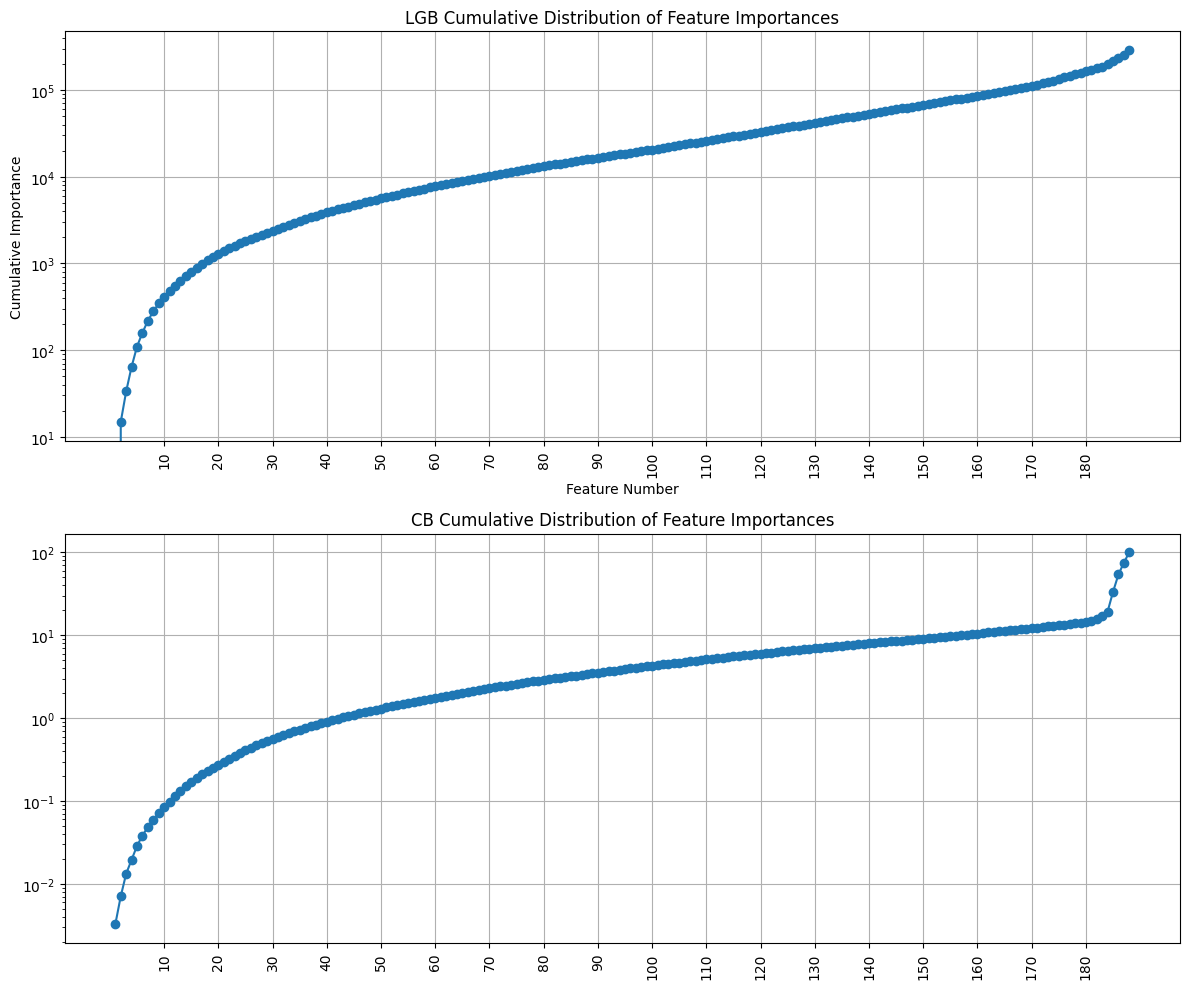

In [38]:
if DO_FEATURE_IMPORTANCE_MODELS:

    # Cumulative feature importance

    fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(12, 10))

    #LGBM
    cumulative_importance_lgb = np.cumsum(lgb_feature_importance_df['importance'])
    tick_positions_lgb = range(10, len(lgb_feature_importance_df) + 1, 10)
    tick_labels_lgb = range(10, len(lgb_feature_importance_df) + 1, 10)

    ax1.plot(range(1, len(lgb_feature_importance_df) + 1), cumulative_importance_lgb, marker='o')
    ax1.set_xticks(tick_positions_lgb)
    ax1.set_xticklabels(tick_labels_lgb, rotation=90)
    ax1.set_yscale('log')
    ax1.set_xlabel('Feature Number')
    ax1.set_ylabel('Cumulative Importance')
    ax1.set_title('LGB Cumulative Distribution of Feature Importances')
    ax1.grid(True)
    
    #CB
    cumulative_importance_cb = np.cumsum(cb_feature_importance_df['importance'])
    tick_positions_cb = range(10, len(cb_feature_importance_df) + 1, 10)
    tick_labels_cb = range(10, len(cb_feature_importance_df) + 1, 10)

    ax3.plot(range(1, len(cb_feature_importance_df) + 1), cumulative_importance_cb, marker='o')
    ax3.set_xticks(tick_positions_cb)
    ax3.set_xticklabels(tick_labels_cb, rotation=90)
    ax3.set_yscale('log')
    ax1.set_xlabel('Feature Number')
    ax1.set_ylabel('Cumulative Importance')
    ax3.set_title('CB Cumulative Distribution of Feature Importances')
    ax3.grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.show()

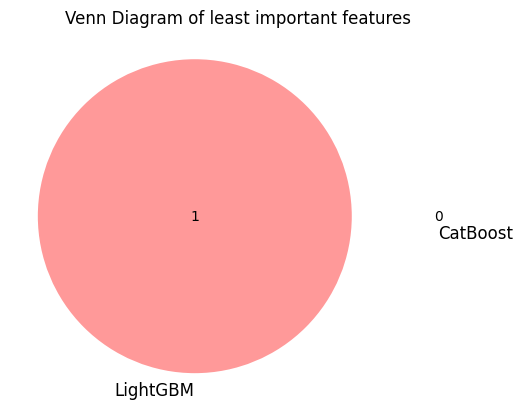

Least important features found in LGB model: {'age_bin_tbp_lv_areaMM2_std'}
Least important features found in CatBoost model: set()
Least important features found in both models: set()


In [39]:
if DO_FEATURE_IMPORTANCE_MODELS:

    lgb_least_important = set(lgb_feature_importance_df.query('importance == 0')['feature'])
    catboost_least_important = set(cb_feature_importance_df.query('importance == 0')['feature'])

    if lgb_least_important or catboost_least_important:
        # Create the Venn Diagram
        venn2(subsets=[lgb_least_important, catboost_least_important], set_labels=('LightGBM', 'CatBoost'))
        plt.title("Venn Diagram of least important features")
        plt.show()
        
        print("Least important features found in LGB model:", lgb_least_important)
        print("Least important features found in CatBoost model:", catboost_least_important)
        print("Least important features found in both models:", lgb_least_important.intersection(catboost_least_important))
    else:
        print("No least important features found in either model.")

# HYPERPARAMETER TUNNING WITH ENSEMBLE

```python
Trial 41 finished with value: 0.18650000369987402
Number of finished trials: 50
Best trial: {'lgb_lambda_l1': 2.4780984933595493, 'lgb_lambda_l2': 0.0003320433322860283, 'lgb_learning_rate': 0.02514254095910542, 'lgb_num_leaves': 184, 'lgb_colsample_bytree': 0.49171538266701276, 'lgb_colsample_bynode': 0.49105262882559153, 'lgb_bagging_fraction': 0.7628011411660247, 'lgb_bagging_freq': 2, 'lgb_min_data_in_leaf': 6, 'lgb_scale_pos_weight': 2.647017537638641, 'cb_learning_rate': 0.010787410920122845, 'cb_l2_leaf_reg': 0.1232478349302498, 'cb_colsample_bylevel': 0.14069853691628093, 'cb_min_data_in_leaf': 53, 'cb_scale_pos_weight': 0.21281184927505495}
```

In [42]:
TUNNING = False

In [43]:
if TUNNING:
    def objective(trial):
        lgb_params = {
            'objective': 'binary',
            'verbosity': -1,
            'n_estimators': 300,
            'boosting_type': 'gbdt',
            'random_state': seed,
            'max_depth': 4,
            'lambda_l1': trial.suggest_float('lgb_lambda_l1', 1e-4, 10.0, log=True),
            'lambda_l2': trial.suggest_float('lgb_lambda_l2', 1e-4, 10.0, log=True),
            'learning_rate': trial.suggest_float('lgb_learning_rate', 1e-3, 1.0, log=True),
            'num_leaves': trial.suggest_int('lgb_num_leaves', 2, 256),
            'colsample_bytree': trial.suggest_float('lgb_colsample_bytree', 0.1, 1.0),
            'colsample_bynode': trial.suggest_float('lgb_colsample_bynode', 0.1, 1.0),
            'bagging_fraction': trial.suggest_float('lgb_bagging_fraction', 0.1, 1.0),
            'bagging_freq': trial.suggest_int('lgb_bagging_freq', 0, 10),
            'min_data_in_leaf': trial.suggest_int('lgb_min_data_in_leaf', 1, 100),
            'scale_pos_weight': trial.suggest_float('lgb_scale_pos_weight', 1e-2, 10.0, log=True),
        }

        cb_params = {
            'loss_function': 'Logloss',
            'iterations': 300,
            'verbose': False,
            'random_state': seed,
            'bootstrap_type': 'Bayesian',
            'learning_rate': trial.suggest_float('cb_learning_rate', 1e-3, 1.0, log=True),
            'max_depth': 8,
            'l2_leaf_reg': trial.suggest_float('cb_l2_leaf_reg', 1e-3, 10.0, log=True),
            'colsample_bylevel': trial.suggest_float('cb_colsample_bylevel', 0.1, 1.0),
            'min_data_in_leaf': trial.suggest_int('cb_min_data_in_leaf', 1, 100),
            'scale_pos_weight': trial.suggest_float('cb_scale_pos_weight', 1e-2, 10.0, log=True),
            'cat_features': cat_cols,
        }

        cb_model = cb.CatBoostClassifier(**cb_params)
        lgb_model = lgb.LGBMClassifier(**lgb_params)

        ensemble = VotingClassifier(estimators=[('cb', cb_model), ('lgb', lgb_model)], voting='soft')

        gkf = StratifiedGroupKFold(5, shuffle=True, random_state=seed)

        validation_scores = []
        recall_scores = []

        # Perform cross-validation
        for fold, (train_index, valid_index) in enumerate(gkf.split(X, y, groups)):

            # Split the data into training and validation sets for the current fold
            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

            if DO_SMOTE:
                X_train, y_train = smote_oversample(X_train, y_train, sampling_strategy=sampling_smote, k_neighbors=2, random_state=seed)

            X_train.loc[:, cat_cols] = X_train[cat_cols].astype('category')
            X_valid.loc[:, cat_cols] = X_valid[cat_cols].astype('category')

            ensemble.fit(X_train, y_train)

            val_score = custom_metric(ensemble, X_valid, y_valid)
            train_score = custom_metric(ensemble, X_train, y_train)
            validation_scores.append(val_score)
            recall = recall_metric(y_valid, ensemble.predict_proba(X_valid)[:, 1], threshold=0.5)
            train_recall = recall_metric(y_train, ensemble.predict_proba(X_train)[:, 1], threshold=0.5)
            recall_scores.append(recall)

        print(f"New aprox number of positive samples: {Counter(y_train)[1]}")
        print(f"Mean Validation Score: {round(np.mean(validation_scores), 5)}")
        print(f"Mean Recall: {round(np.mean(recall_scores), 5)}")

        return np.mean(validation_scores)

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)

    print('Number of finished trials:', len(study.trials))
    print('Best trial:', study.best_trial.params)

# TEST PREDICTION

**With ensemble**

In [40]:
if ENSEMBLE:
    df_test.loc[:, cat_cols] = df_test[cat_cols].astype('category')
    df_subm['target'] = ensemble.predict_proba(df_test[feature_cols])[:, 1]
    df_subm.to_csv('submission.csv')
    print(df_subm.head())

                target
isic_id               
ISIC_0015657  0.010826
ISIC_0015729  0.000060
ISIC_0015740  0.002408


**With individual models averaged**

In [41]:
if not ENSEMBLE:
    
    def predict_test_data(X_test, cb_models, lgb_models, cb_weight=0.5, lgb_weight=0.5):
        cb_preds = np.mean([model.predict_proba(X_test)[:, 1] for model in cb_models], axis=0)
        lgb_preds = np.mean([model.predict_proba(X_test)[:, 1] for model in lgb_models], axis=0)

        final_preds = (cb_preds * cb_weight + lgb_preds * lgb_weight) / (cb_weight + lgb_weight)

        return final_preds

    df_test.loc[:, cat_cols] = df_test[cat_cols].astype('category')
    df_subm['target'] = predict_test_data(df_test[feature_cols], cb_models, lgb_models, cb_weight=0.5, lgb_weight=0.5)
    df_subm.to_csv('submission.csv')
    print(df_subm.head())